# <font color='#4C5FDA'>**Breast Cancer Detection Based on CNNs Using Thermal Imaging** </font>

Original paper by Juan Pablo Zuluaga, Zeina Al Masry, Khaled Benaggoune, Safa Meraghni & Noureddine Zerhouni: [A CNN-based methodology for breast cancer diagnosis using thermal images](https://www.tandfonline.com/doi/full/10.1080/21681163.2020.1824685)

In [1]:
#@title **Instalar paquetes necesarios**

%%capture
! pip install torchmetrics
! pip install wandb -Uq
! pip install onnx

In [5]:
#@title **Importamos librerías necesarias**

# Data manipulation
import numpy as np
import pandas as pd
# import cv2
import os
# import matplotlib.pyplot as plt
from PIL import Image, ImageOps


# Pytorch essentials
import torch
import torch.nn as nn
import torch.nn.functional as F

# PyTorch torchvision
from torchvision.transforms import v2

# Pytorch metrics
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score, BinaryRecall, BinaryPrecision

# Pytorch essentials for datasets.
from torch.utils.data import Dataset, DataLoader

# sklearn
from sklearn.model_selection import GroupKFold, GroupShuffleSplit

# wandb
import wandb
wandb.login()

True

## <font color='#ECA702'>**Configuración inicial para conectarnos con Kaggle**</font>

1. Instalamos kaggle. Para poder usar comandos de Kaggle.

In [3]:
! pip install kaggle

Subimos nuestro token de autenticación de Kaggle (si estamos en colab, sino colocarlo en la carpeta del proyecto)

In [ ]:
from google.colab import files
files.upload()

1. Creamos los directorios de Kaggle
2. Copiamos nuestro token en .kaggle
3. Con `chmod 600` establecemos los permitos del token en 600, es decir, que solo yo tengo permisos de lectura y escritura sobre el archivo

In [5]:
! mkdir ~/kaggle

In [6]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

## <font color='#ECA702'>**Procesamiento del dataset**</font>

### <font color='#52F17F'>**Carga del dataset**</font>

Traemos el dataset [Thermal Images for Breast Cancer Diagnosis DMR-IR](https://www.kaggle.com/datasets/asdeepak/thermal-images-for-breast-cancer-diagnosis-dmrir) desde kaggle.

This dataset is a methodology for breast disease computer-aided diagnosis using dynamic thermography. The thermal images for breast tumors are classified according to DMR-IR standards.

Two types of tumors are classified in this dataset one is benign another is malignant.
- Benign: This type of tumor is usually well-defined and round or oval in shape. (non-cancerous tumor)
- Malignant: This type of tumor is usually poorly defined and irregular with lobules. (cancerous tumor)

In [11]:
! kaggle datasets download -d asdeepak/thermal-images-for-breast-cancer-diagnosis-dmrir
! unzip thermal-images-for-breast-cancer-diagnosis-dmrir.zip

Dataset URL: https://www.kaggle.com/datasets/asdeepak/thermal-images-for-breast-cancer-diagnosis-dmrir
License(s): copyright-authors
 98% 521M/530M [00:11<00:00, 71.6MB/s]
100% 530M/530M [00:11<00:00, 49.6MB/s]
Archive:  thermal-images-for-breast-cancer-diagnosis-dmrir.zip
  inflating: Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/1050/Matrizes/PAC_65_DN0.txt  
  inflating: Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/1050/Matrizes/PAC_65_DN1.txt  
  inflating: Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/1050/Matrizes/PAC_65_DN10.txt  
  inflating: Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/1050/Matrizes/PAC_65_DN11.txt  
  inflating: Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/1050/Matrizes/PAC_65_DN12.txt  
  inflating: Imagens e Matrizes da Tese de Thiag

Después de descargar los datos. Debemos entender la estructura de las carpetas para poder trabajar con ellas de una mejor manera.
1. La carpeta principal `Imagens e Matrizes da Tese de Thiago Alves Elias da Silva` son todos los datos `data`.
2. La carpeta `12 Novos Casos de Testes` la podemos tomar como nuestro conjunto de prueba (`test`).
3. Mientras que la carpeta `Desenvolvimento da Metodologia` será nuestro conjunto de entrenamiento (`train`).

Luego dentro de nuestras carpetas de `train` y `test` encontramos dos categorías `DOENTES`y `SAUDAтХа├╝VEIS` o SAUDÁVEI. Los primeros son los casos malignos y los segundos benignos.

Dentro de cada una de las carpetas de pacientes saludables y enfermos se encuentran carpetas con números, cada número representa un paciente. Y para cada paciente tendremos dos carpetas más, una para las imágenes **segmentadas** en escala de grises y la otra para la matrix o mapa de calor.

Algo bueno de este dataset es que ya está dividido por pacientes, es decir, no tendremos imagenes del mismo paciente en el conjunto de entrenamiento y testeo. Por lo tanto, vamos a entrenar con N pacientes, y testear con K pacientes, que no son los mismos.

### <font color='#52F17F'>**Creación del DataFrame Pandas auxiliar**</font>

In [6]:
TEST_PATH = "Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes"
TRAIN_PATH = "Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia"

patients = []
labels = []
segmented_images = []
matrices = []

"""
Esta construcción del dataset depende de la estructura del mismo
"""

# Primero consigo la ruta de imagenes y matrices para cada uno de los pacientes

for category in os.listdir(TEST_PATH):
  # print(category)
  for patient in os.listdir(os.path.join(TEST_PATH, category)):
    patient_path = os.path.join(TEST_PATH, category, patient)
    # print(patient_path)
    for record in os.listdir(f'{patient_path}/Segmentadas'):
      record_path = os.path.join(f'{patient_path}/Segmentadas', record)
      # print(record_path)
      segmented_images.append(record_path)
      if '-dir.png' in record_path:
        matrix_path = os.path.join(record_path.replace('Segmentadas','Matrizes').replace("-dir.png", ".txt"))
      elif '-esq.png' in record_path:
        matrix_path = os.path.join(record_path.replace('Segmentadas','Matrizes').replace("-esq.png", ".txt"))
      # print(matrix_path)
      if os.path.exists(matrix_path):
        matrices.append(matrix_path)
      else:
        good_part, bad_part = matrix_path[:len(matrix_path)//2], matrix_path[len(matrix_path)//2:]
        bad_part = bad_part.replace('Matrizes', 'Matrizes de Temperatura')
        matrix_path = good_part+bad_part
        matrices.append(matrix_path)
        # print(matrix_path)

      label = patient_path.split('/')[2]
      if label == 'DOENTES':
        label = 1
      else:
        label = 0
      labels.append(label)
      patients.append(record.split('_')[1])

for category in os.listdir(TRAIN_PATH):
  # print(category)
  for patient in os.listdir(os.path.join(TRAIN_PATH, category)):
    patient_path = os.path.join(TRAIN_PATH, category, patient)
    for record in os.listdir(f'{patient_path}/Segmentadas'):
      record_path = os.path.join(f'{patient_path}/Segmentadas', record)
      # print(record_path)
      segmented_images.append(record_path)
      if '-dir.png' in record_path:
        matrix_path = os.path.join(record_path.replace('Segmentadas','Matrizes').replace("-dir.png", ".txt"))
      elif '-esq.png' in record_path:
        matrix_path = os.path.join(record_path.replace('Segmentadas','Matrizes').replace("-esq.png", ".txt"))
      # print(matrix_path)
      if os.path.exists(matrix_path):
        matrices.append(matrix_path)
      else:
        good_part, bad_part = matrix_path[:len(matrix_path)//2], matrix_path[len(matrix_path)//2:]
        bad_part = bad_part.replace('Matrizes', 'Matrizes de Temperatura')
        matrix_path = good_part+bad_part
        matrices.append(matrix_path)
        # print(matrix_path)

      label = patient_path.split('/')[2]
      if label == 'DOENTES':
        label = 1
      else:
        label = 0
      labels.append(label)
      patients.append(record.split('_')[1])

# Crear un DataFrame con la información
data = pd.DataFrame({
    'patient': patients,
    'segmented_image': segmented_images,
    'matrix': matrices,
    'label': labels
})

data.set_index('patient', inplace=True)
data.head()

,segmented_image,matrix,label
patient,,,
14,Imagens e Matrizes da Tese de Thiago Alves Eli...,Imagens e Matrizes da Tese de Thiago Alves Eli...,0
14,Imagens e Matrizes da Tese de Thiago Alves Eli...,Imagens e Matrizes da Tese de Thiago Alves Eli...,0
14,Imagens e Matrizes da Tese de Thiago Alves Eli...,Imagens e Matrizes da Tese de Thiago Alves Eli...,0
14,Imagens e Matrizes da Tese de Thiago Alves Eli...,Imagens e Matrizes da Tese de Thiago Alves Eli...,0
14,Imagens e Matrizes da Tese de Thiago Alves Eli...,Imagens e Matrizes da Tese de Thiago Alves Eli...,0


In [7]:
# Contar la cantidad de pacientes con cáncer y sanos
total_con_cancer = data[data['label'] == 1].index.nunique()
total_sanos = data[data['label'] == 0].index.nunique()

print(f'Cantidad total de pacientes con cáncer: {total_con_cancer}')
print(f'Cantidad total de pacientes sanos: {total_sanos}')

Cantidad total de pacientes con cáncer: 37
Cantidad total de pacientes sanos: 19


### <font color='#52F17F'>**Creación del Dataset PyTorch**</font>

In [14]:
"""
Constante encontrada al iterar por todas las imágenes segmentadas,
calcular su valor máximo de temperatura y devolver el máximo de todas.
"""

MAX_TEMPERATURE = 36.44

In [15]:
class ThermalDataset(Dataset):
  def __init__(self, dataframe, transform = None, normalize = None):
    self.dataframe = dataframe
    self.normalize = normalize
    self.transform = transform

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, index):

    """ Carga de la imagen """

    # Entramos a la carpeta y conseguimos la imagen de la lista
    img_path = self.dataframe['segmented_image'][index]

    # Leemos la imagen segmentada en escala de grises
    img = Image.open(img_path)
    img = ImageOps.grayscale(img)
    img = np.array(img)

    """ Carga de la matrix """

    matrix_path = self.dataframe['matrix'][index]
    # print(matrix_path)

    matrix = np.loadtxt(matrix_path, dtype=np.float32) # https://www.geeksforgeeks.org/import-text-files-into-numpy-arrays/

    """ Consigo la imagen segmentada con los valores de la matrix """

    segmented = np.where(img==0, 0, 1) # int64
    # segmented = img * matrix
    img = (matrix * segmented).astype(np.float32) # float32, shape (480, 640)

    # Le agrego un canal explícito
    img = np.expand_dims(img, axis=2) # https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html

    if self.normalize:
      img /= MAX_TEMPERATURE

    """ Consiguiendo el label """

    label = self.dataframe['label'][index]

    """ Convertir las imagenes en tensores y hacer resize """
    if self.transform:
      # Aplicamos las transformaciones a la imagen
      # print(type(img), img.shape)
      img = self.transform(img)

    return img, label

En teoría por cada paciente tenemos 20 imagenes, pero las cuentas no cuadran, por ejemplo en testeo deberíamos tener 9x20 = 180 imagenes, pero aparecen 240. Esto sucede debido a que hay algunas imagenes que están separadas en la parte izquierda y derecha.

Para el conjunto de entrenamiento tampoco cuadra el número de matrices. Esto es debido a que algunos pacientes tienen una matriz que se llama `ESTATICO` que no tengo ni idea para qué es pero no es problema ya que no hace 'match' con ninguna imágen.

In [16]:
# Todas las imagenes vienen en h: 480, w: 640. El objetivo es disminuir el tamaño
# sin perder la relación de aspecto. https://gist.github.com/tomvon/ae288482869b495201a0

HEIGHT = 300
r = HEIGHT/480 # Calculo la relación de aspecto.
WIDTH = int(640*r)
# print(f"Las imagenes son reescaladas a {HEIGHT}x{WIDTH}")

# https://pytorch.org/vision/main/transforms.html#performance-considerations
transform = v2.Compose([
    v2.ToImage(),
    # v2.Resize(size=(HEIGHT, WIDTH), antialias=True),
    # v2.ToDtype(torch.float32),
    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [20]:
complete_dataset = ThermalDataset(data, transform=transform, normalize=True)
print(complete_dataset.__len__())
print(complete_dataset[1180][0].shape, complete_dataset[1180][1], complete_dataset[1180][0].min(), complete_dataset[1180][0].max())

1522
torch.Size([1, 480, 640]) 1 tensor(0.) tensor(0.9561)


### <font color='#52F17F'>**Partición de los datos**</font>

In [8]:
def make_folds(data):
    # Extraer los datos para GroupKFold https://discuss.pytorch.org/t/custom-datatype-for-many-images-to-one-label/87629
    X = np.array([i for i in range(len(data))])
    y = data['label'].values
    groups = data.index.values

    folds_dict = {}

    groupk_folds = 7
    gkf = GroupKFold(n_splits=groupk_folds)

    # Realizar la validación cruzada por grupos
    for i, (train_index, test_index) in enumerate(gkf.split(X, y, groups), 1):
        train_groups = groups[train_index]
        test_groups = groups[test_index]

        gss = GroupShuffleSplit(n_splits=1, test_size=0.16, random_state=42)
        train_idx, val_idx = next(gss.split(train_index, y[train_index], groups=train_groups))

        groups_train = train_groups[train_idx]
        groups_val = train_groups[val_idx]

        fold_name = f"fold_{i}"
        folds_dict[fold_name] = {
            'train': train_index[train_idx],
            'val': train_index[val_idx],
            'test': test_index
        }

        print(f"División {i}:")
        print("  Pacientes en entrenamiento:", np.unique(groups_train))
        print("  Pacientes en validación:", np.unique(groups_val))
        print("  Pacientes en prueba:", np.unique(test_groups))
        print("  Número de pacientes en entrenamiento:", len(np.unique(groups_train)))
        print("  Número de pacientes en validación:", len(np.unique(groups_val)))
        print("  Número de pacientes en prueba:", len(np.unique(test_groups)))

    return folds_dict

In [9]:

folds = make_folds(data)

División 1:
  Pacientes en entrenamiento: ['00' '01' '02' '04' '05' '07' '08' '09' '11' '13' '14' '15' '24' '25'
 '26' '28' '29' '31' '35' '36' '37' '38' '40' '43' '44' '45' '46' '48'
 '49' '51' '53' '54' '56' '58' '61' '62' '64' '65' '66' '69']
  Pacientes en validación: ['16' '32' '39' '41' '42' '55' '59' '63']
  Pacientes en prueba: ['03' '06' '17' '27' '30' '34' '52' '60']
  Número de pacientes en entrenamiento: 40
  Número de pacientes en validación: 8
  Número de pacientes en prueba: 8
División 2:
  Pacientes en entrenamiento: ['00' '01' '02' '03' '04' '05' '06' '08' '09' '11' '13' '14' '16' '17'
 '24' '25' '27' '28' '30' '31' '32' '34' '36' '39' '40' '42' '43' '44'
 '45' '46' '49' '52' '54' '55' '60' '61' '63' '64' '65' '66']
  Pacientes en validación: ['15' '29' '35' '37' '38' '53' '58' '62']
  Pacientes en prueba: ['07' '26' '41' '48' '51' '56' '59' '69']
  Número de pacientes en entrenamiento: 40
  Número de pacientes en validación: 8
  Número de pacientes en prueba: 8
Divisi

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


División 1:
  Pacientes en entrenamiento: ['00' '01' '02' '04' '05' '07' '08' '09' '11' '13' '14' '15' '24' '25'
 '26' '28' '29' '31' '35' '36' '37' '38' '40' '43' '44' '45' '46' '48'
 '49' '51' '53' '54' '56' '58' '61' '62' '64' '65' '66' '69']
  Pacientes en validación: ['16' '32' '39' '41' '42' '55' '59' '63']
  Pacientes en prueba: ['03' '06' '17' '27' '30' '34' '52' '60']
  Número de pacientes en entrenamiento: 40
  Número de pacientes en validación: 8
  Número de pacientes en prueba: 8
División 2:
  Pacientes en entrenamiento: ['00' '01' '02' '03' '04' '05' '06' '08' '09' '11' '13' '14' '16' '17'
 '24' '25' '27' '28' '30' '31' '32' '34' '36' '39' '40' '42' '43' '44'
 '45' '46' '49' '52' '54' '55' '60' '61' '63' '64' '65' '66']
  Pacientes en validación: ['15' '29' '35' '37' '38' '53' '58' '62']
  Pacientes en prueba: ['07' '26' '41' '48' '51' '56' '59' '69']
  Número de pacientes en entrenamiento: 40
  Número de pacientes en validación: 8
  Número de pacientes en prueba: 8
Divisi

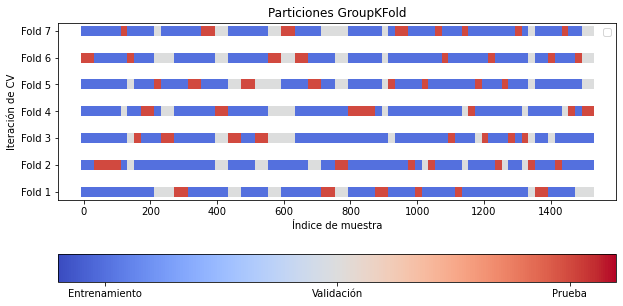

NameError: name 'Rectangle' is not defined

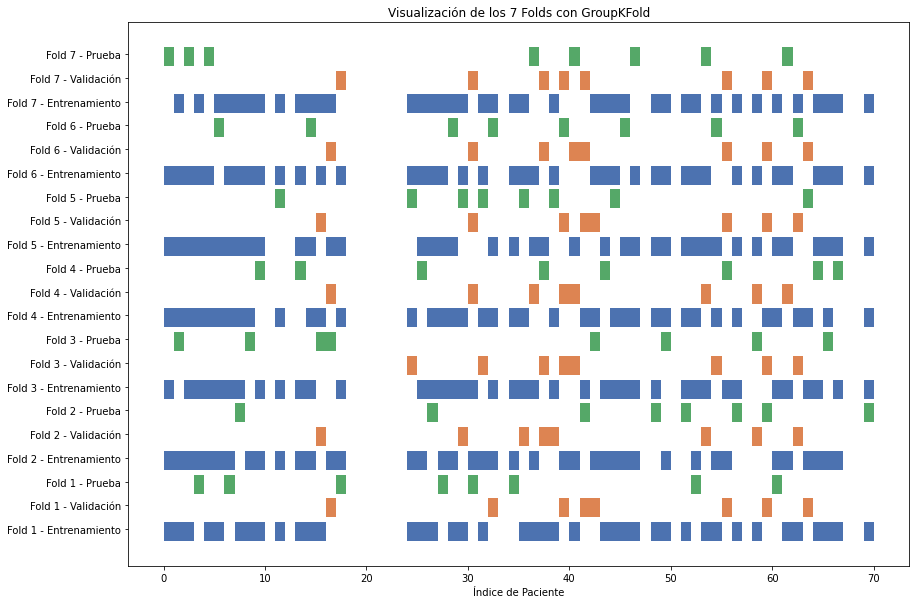

In [10]:
print("Diccionario de folds:")
for fold, indices in folds.items():
    print(f"\n{fold}:")
    print("  Entrenamiento:", indices['train'])
    print("  Validación:", indices['val'])
    print("  Prueba:", indices['test'])

Diccionario de folds:

fold_1:
  Entrenamiento: [   0    1    2 ... 1479 1480 1481]
  Validación: [ 220  221  222  223  224  225  226  227  228  229  230  231  232  233
  234  235  236  237  238  239  240  241  242  243  244  245  246  247
  248  249  250  251  252  253  254  255  256  257  258  259  260  261
  262  263  264  265  266  267  268  269  270  271  272  273  274  275
  276  277  278  279  442  443  444  445  446  447  448  449  450  451
  452  453  454  455  456  457  458  459  460  461  462  463  464  465
  466  467  468  469  470  471  472  473  474  475  476  477  478  479
  480  481  562  563  564  565  566  567  568  569  570  571  572  573
  574  575  576  577  578  579  580  581  582  583  584  585  586  587
  588  589  590  591  592  593  594  595  596  597  598  599  600  601
  762  763  764  765  766  767  768  769  770  771  772  773  774  775
  776  777  778  779  780  781  782  783  784  785  786  787  788  789
  790  791  792  793  794  795  796  797  798  799

### <font color='#52F17F'>**Make's for wandb**</font>

In [23]:
def get_data(train_index, test_index, data):
    full_dataset = ThermalDataset(data, transform=transform)

    train_subset = torch.utils.data.Subset(full_dataset, train_index)
    test_subset = torch.utils.data.Subset(full_dataset, test_index)

    return train_subset, test_subset


def make_loader(dataset, batch_size):
    loader = torch.utils.data.DataLoader(dataset=dataset,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         pin_memory=True, num_workers=2)
    return loader

def build_optimizer(network, optimizer, learning_rate):
    if optimizer == "sgd":
        optimizer = torch.optim.SGD(network.parameters(),
                              lr=learning_rate, momentum=0.9)
    elif optimizer == "adam":
        optimizer = torch.optim.Adam(network.parameters(),
                               lr=learning_rate)
    return optimizer

## <font color='#ECA702'>**Modelo CNN**</font>

### <font color='#52F17F'>**Creando el modelo**</font>

In [24]:
# Conventional and convolutional neural network

class ConvNet(nn.Module):
    def __init__(self, kernels, classes=1, input_size=[1, 480, 640]):
        super(ConvNet, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, kernels[0], kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(kernels[0], kernels[1], kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7 * 7 * kernels[-1], classes)

        self.input_size = input_size
        self.kernels = kernels

        self.final_feature_size = self.calculate_final_feature_size()
        # Adjust the fully connected layer to use the final feature size
        self.fc = nn.Linear(self.final_feature_size, classes)

    def calculate_final_feature_size(self):
        size_h, size_w = self.input_size[1:]
        size_h = self.conv_output_size(size_h, 5, 1, 2) // 2  # layer1 height
        size_w = self.conv_output_size(size_w, 5, 1, 2) // 2  # layer1 width

        size_h = self.conv_output_size(size_h, 5, 1, 2) // 2  # layer2 height
        size_w = self.conv_output_size(size_w, 5, 1, 2) // 2  # layer2 width

        return size_h * size_w * self.kernels[-1]

    def conv_output_size(self, size, kernel_size, stride, padding):
        return (size - kernel_size + 2 * padding) // stride + 1

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [25]:
# Test al modelo, para ver si nos entrega la salida esperada

input_image = complete_dataset[0][0].unsqueeze(0)
print(f"Entrada: {input_image.size(), {input_image.dtype}}")
model = ConvNet(kernels=[32, 64])
ouput = model(input_image)
print(f"Salida: {ouput.size(), ouput.dtype}") # Esperado: [1, 2] (batch 1, 2 clases)

Entrada: (torch.Size([1, 1, 480, 640]), {torch.float32})
Salida: (torch.Size([1, 1]), torch.float32)


### <font color='#52F17F'>**Entrenamiento del modelo**</font>

In [27]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def make(config, train_index, test_index, data):
    # Make the data
    train, test = get_data(train_index, test_index, data)
    train_loader = make_loader(train, batch_size=config.batch_size)
    test_loader = make_loader(test, batch_size=config.batch_size)

    # Make the model
    model = ConvNet(kernels=config.features, classes=config.classes).to(DEVICE)

    # Make the loss and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = build_optimizer(model, config.optimizer, config.learning_rate)

    # N-epochs to train
    epochs = config.epochs

    # Make metrics
    accuracy_fn = BinaryAccuracy().to(DEVICE)
    f1_score_fn = BinaryF1Score().to(DEVICE)
    recall_fn = BinaryRecall().to(DEVICE)
    precision_fn = BinaryPrecision().to(DEVICE)

    return model, train_loader, test_loader, criterion, optimizer, accuracy_fn, f1_score_fn, recall_fn, precision_fn, epochs

#### <font color='##6600CC'>**Training loop**</font>

In [29]:
def train_log(loss, accuracy, step, current):
    """ Log the metrics for the current batch into wandb

    Args:
        loss: the value of the loss at current batch
        accuracy: the value of the accuracy at current batch
        step: actual step
        current: actual batch
    """

    # Where the magic happens
    # wandb.log({"step":step, "loss": loss, "accuracy": accuracy}, step=step)
    wandb.log({"step":step, "train_loss": loss, "train_accuracy": accuracy})
    print(f"train loss: {loss:.3f} accuracy: {accuracy:.3f} [after {current} batches]")

In [30]:
def train_batch(images, labels, model, optimizer, criterion, metrics_fn):
    """Train the model on a single bacth of the dataloader.

    Args:
        dataloader: an instance of `torch.utils.data.DataLoader`, containing the training data.
        model: an instance of `torch.nn.Module`, the model to be trained.
        optimizer: an instance of `torch.optim.Optimizer`, the optimizer used for training.
        criterion: a callable, the loss function.
        metrics_fn: a callable, the metrics function.

    Returns:
        loss: the value of the loss at current batch
        accuracy: the value of the accuracy at current batch
    """

    images, labels = images.to(DEVICE), labels.to(DEVICE)

    # Forward pass ➡
    outputs = model(images)
    loss = criterion(outputs, labels.unsqueeze(1).float())
    accuracy = metrics_fn(outputs, labels.unsqueeze(1).float())

    # Backward pass ⬅
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()

    return loss, accuracy

In [31]:
def train(model, loader, criterion, optimizer, metric_fn, step):

    model.train()
    n_prints = int(len(loader)/4)

    # Run training and track with wandb
    for batch, (images, labels) in enumerate(loader):

        loss, accuracy = train_batch(images, labels, model, optimizer, criterion, metric_fn)

        # Report metrics every n_prints batch
        if batch % n_prints == n_prints-1:
            loss, current = loss.item(), batch
            # print(step)
            train_log(loss, accuracy, step, current)
            # Increment the step after logging
            step += 1
    return step

#### <font color='##6600CC'>**Evaluation loop**</font>

In [32]:
def test(model, test_loader, loss_fn, accuracy_fn, f1_score_fn, recall_fn, precision_fn, epoch):
    model.eval()

    # Run the model on some test examples
    num_batches = len(test_loader)
    val_loss, val_accuracy, val_f1, val_recall, val_precision = 0, 0, 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            val_loss += loss_fn(outputs, labels.unsqueeze(1).float()).item()
            val_accuracy += accuracy_fn(outputs, labels.unsqueeze(1).float())
            val_f1 += f1_score_fn(outputs, labels.unsqueeze(1).float())
            val_recall += recall_fn(outputs, labels.unsqueeze(1).float())
            val_precision += precision_fn(outputs, labels.unsqueeze(1).float())

    val_loss /= num_batches
    val_accuracy /= num_batches
    val_f1 /= num_batches
    val_recall /= num_batches
    val_precision /= num_batches

    # Log the evaluation metrics at the end of batches
    wandb.log({"epoch": epoch+1, "val_loss": val_loss, "val_accuracy": val_accuracy, "val_f1": val_f1, "val_recall": val_recall, "val_precision": val_precision})
    print(f"val loss: {val_loss:.3f} accuracy: {val_accuracy:.3f} [after {num_batches} batches]")
    return images, val_accuracy, val_f1, val_recall, val_precision

### <font color='#52F17F'>**Train and watch your metrics on wandb.ai**</font>

In [33]:
if os.path.exists('../models') == False:
  os.mkdir("../models")
MODELS_DIR = "../models"


def model_pipeline(num, sweep_id, sweep_run_name, hyperparameters, train_index, test_index, data):

    # tell wandb to get started
    run_name = f'{sweep_run_name}--{num}'
    with wandb.init(config=hyperparameters, dir=MODELS_DIR
                    , group=sweep_id, job_type=sweep_run_name, name=run_name, reinit=True):
      # access all HPs through wandb.config, so logging matches execution!
      config = wandb.config

      # make the model, data, and optimization problem
      model, train_loader, test_loader, criterion, optimizer, accuracy_fn, f1_score_fn, recall_fn, precision_fn, epochs = make(config,
                                                                                                                                train_index,
                                                                                                                                test_index,
                                                                                                                                data)
      print(model)

      # Tell wandb to watch what the model gets up to: gradients, weights, and more!
      wandb.watch(model, criterion, log="all", log_freq=10)
      # and use them to train the model

      # Initialize the step counter
      step = 0
      best_val_accuracy = 0
      patience = 10

      print(f'FOLD {num+1}')
      print('--------------------------------')

      # Estas métricas son el promedio luego de todas las épocas que alcance a tomar el modelo
      avg_val_accuracy_epochs, avg_val_recall_epochs, avg_val_precision_epochs, avg_val_f1_score_epochs = 0, 0, 0, 0

      for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        step = train(model, train_loader, criterion, optimizer, accuracy_fn, step=step)
        # and test its performance per epoch
        images, val_accuracy, val_f1, val_recall, val_precision = test(model, test_loader, criterion, accuracy_fn, f1_score_fn, recall_fn, precision_fn, epoch=t)

        avg_val_accuracy_epochs += val_accuracy
        avg_val_recall_epochs += val_recall
        avg_val_precision_epochs += val_precision
        avg_val_f1_score_epochs += val_f1

        # Early stopping
        if val_accuracy > best_val_accuracy:
          best_val_accuracy = val_accuracy
          patience = 10  # Reset patience counter
        else:
          patience -= 1
          if patience == 0:
              break

      avg_val_accuracy_epochs /= (t+1)
      avg_val_f1_score_epochs /= (t+1)
      avg_val_recall_epochs /= (t+1)
      avg_val_precision_epochs /= (t+1)

      # Save the model in the exchangeable ONNX format
      torch.onnx.export(model, images,"model.onnx")
      wandb.save("model.onnx")
      wandb.finish()

    return avg_val_accuracy_epochs, avg_val_f1_score_epochs, avg_val_recall_epochs, avg_val_precision_epochs

In [34]:
def reset_wandb_env():
    exclude = {
        "WANDB_PROJECT",
        "WANDB_ENTITY",
        "WANDB_API_KEY",
    }
    for key in os.environ.keys():
        if key.startswith("WANDB_") and key not in exclude:
            del os.environ[key]

In [35]:
def cross_validate():
    num_folds = 4
    gkf = GroupKFold(n_splits=num_folds)

    # Extraer los datos para GroupKFold https://discuss.pytorch.org/t/custom-datatype-for-many-images-to-one-label/87629
    X = [i for i in range(len(data))]
    y = data['label'].values
    groups = data.index.values


    sweep_run = wandb.init(dir=MODELS_DIR)
    sweep_id = sweep_run.sweep_id or "unknown"
    sweep_url = sweep_run.get_sweep_url()
    project_url = sweep_run.get_project_url()
    sweep_group_url = f'{project_url}/groups/{sweep_id}'
    sweep_run.notes = sweep_group_url
    sweep_run.save()
    sweep_run_name = sweep_run.name or sweep_run.id or "unknown_2"
    sweep_run_id = sweep_run.id
    sweep_run.finish()
    wandb.sdk.wandb_setup._setup(_reset=True)

    metrics = {
        "val_accuracy": [],
        "val_recall": [],
        "val_precision": [],
        "val_f1_score": []
    }
    for fold, (train_ids, test_ids) in enumerate(gkf.split(X, y, groups)):


        reset_wandb_env()

        # Entreno y valido cada run pasandole el sweep y la config
        val_accuracy, val_f1, val_recall, val_precision = model_pipeline(
            sweep_id=sweep_id, num=fold,
            sweep_run_name=sweep_run_name,
            hyperparameters=dict(sweep_run.config),
            train_index=train_ids,
            test_index=test_ids,
            data=data
        )
        metrics["val_accuracy"].append(val_accuracy)
        metrics["val_recall"].append(val_f1)
        metrics["val_precision"].append(val_recall)
        metrics["val_f1_score"].append(val_precision)

    # resume the sweep run
    sweep_run = wandb.init(id=sweep_run_id, resume="must", dir=MODELS_DIR)

    # Calcula los promedios de cada métrica
    avg_val_accuracy = sum(metrics["val_accuracy"]) / len(metrics["val_accuracy"])
    avg_val_recall = sum(metrics["val_recall"]) / len(metrics["val_recall"])
    avg_val_precision = sum(metrics["val_precision"]) / len(metrics["val_precision"])
    avg_val_f1_score = sum(metrics["val_f1_score"]) / len(metrics["val_f1_score"])
    # Log metrics to sweep run
    sweep_run.log({
        "val_accuracy": avg_val_accuracy,
        "val_recall": avg_val_recall,
        "val_precision": avg_val_precision,
        "val_f1": avg_val_f1_score
    })
    sweep_run.finish()

    print("*" * 40)
    print("Sweep URL:       ", sweep_url)
    print("Sweep Group URL: ", sweep_group_url)
    print("*" * 40)

### <font color='#52F17F'>**Configuración de busqueda de hiperparametros**</font>

In [36]:
sweep_configuration = {
    'method': 'random',
    'name': 'sweep-test-1',
    'metric': {
        'goal': 'maximize',
        'name': 'val_accuracy'
    },
    'parameters': {
        'epochs': {'value': 50},
        'classes': {'value': 1},
        'features': {'values': [[8, 16], [16, 32]]},
        'batch_size': {'values': [16, 32, 64]},
        'learning_rate': {'values': [0.01, 0.001, 0.0001]},
        'optimizer': {'values': ['adam', 'sgd']},
        'dataset': {'value': 'ThermalBreastCancer'},
        'architecture': {'value': 'CNN'}
    },
    # 'early_terminate': {
    #     'type': 'hyperband',
    #     'eta': 2,
    #     'min_iter':2
    #  }
}

In [ ]:
sweep_id = wandb.sweep(sweep_configuration, project='dip-project')

Create sweep with ID: yi65n01e
Sweep URL: https://wandb.ai/aiuis/dip-project/sweeps/yi65n01e


In [ ]:
# sweep_id = wandb.sweep(sweep_configuration, project='dip-project')
wandb.agent("yad1fy92", function=cross_validate, count=3)

wandb.finish()

wandb: Agent Starting Run: 9sdvte8b with config:
wandb: 	architecture: CNN
wandb: 	batch_size: 64
wandb: 	classes: 1
wandb: 	dataset: ParkinsonVideo
wandb: 	epochs: 50
wandb: 	features: [16, 32]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=614400, out_features=1, bias=True)
)
FOLD 1
--------------------------------
Epoch 1
-------------------------------


/home/guillermo/miniforge3/envs/wandb-tutorial/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Traceback (most recent call last):
  File "/tmp/ipykernel_4448/1545842686.py", line 39, in model_pipeline
    step = train(model, train_loader, criterion, optimizer, accuracy_fn, step=step)
  File "/tmp/ipykernel_4448/1618031750.py", line 9, in train
    loss, accuracy = train_batch(images, labels, model, optimizer, criterion, metric_fn)
  File "/tmp/ipykernel_4448/2864932988.py", line 25, in train_batch
    loss.backward()
  File "/home/guillermo/miniforge3/envs/wandb-tutorial/lib/python3.10/site-packages/torch/_tensor.py", line 525, in backward
    torch.autograd.backward(
  File "/home/guillermo/m

Run 9sdvte8b errored:
Traceback (most recent call last):
  File "/home/guillermo/miniforge3/envs/wandb-tutorial/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 307, in _run_job
    self._function()
  File "/tmp/ipykernel_4448/2188155363.py", line 35, in cross_validate
    val_accuracy, val_f1, val_recall, val_precision = model_pipeline(
  File "/tmp/ipykernel_4448/1545842686.py", line 39, in model_pipeline
    step = train(model, train_loader, criterion, optimizer, accuracy_fn, step=step)
  File "/tmp/ipykernel_4448/1618031750.py", line 9, in train
    loss, accuracy = train_batch(images, labels, model, optimizer, criterion, metric_fn)
  File "/tmp/ipykernel_4448/2864932988.py", line 25, in train_batch
    loss.backward()
  File "/home/guillermo/miniforge3/envs/wandb-tutorial/lib/python3.10/site-packages/torch/_tensor.py", line 525, in backward
    torch.autograd.backward(
  File "/home/guillermo/miniforge3/envs/wandb-tutorial/lib/python3.10/site-packages/torch/autograd/__i

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=307200, out_features=1, bias=True)
)
FOLD 1
--------------------------------
Epoch 1
-------------------------------
train loss: 0.804 accuracy: 0.688 [after 17 batches]
train loss: 0.183 accuracy: 1.000 [after 35 batches]
train loss: 0.213 accuracy: 1.000 [after 53 batches]
train loss: 0.113 accuracy: 1.000 [after 71 batches]


/home/guillermo/miniforge3/envs/wandb-tutorial/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


val loss: 0.963 accuracy: 0.526 [after 24 batches]
Epoch 2
-------------------------------
train loss: 0.130 accuracy: 0.938 [after 17 batches]
train loss: 0.015 accuracy: 1.000 [after 35 batches]
train loss: 0.010 accuracy: 1.000 [after 53 batches]
train loss: 0.001 accuracy: 1.000 [after 71 batches]
val loss: 1.515 accuracy: 0.510 [after 24 batches]
Epoch 3
-------------------------------
train loss: 0.010 accuracy: 1.000 [after 17 batches]
train loss: 0.037 accuracy: 1.000 [after 35 batches]
train loss: 0.004 accuracy: 1.000 [after 53 batches]
train loss: 0.000 accuracy: 1.000 [after 71 batches]
val loss: 1.832 accuracy: 0.518 [after 24 batches]
Epoch 4
-------------------------------
train loss: 0.005 accuracy: 1.000 [after 17 batches]
train loss: 0.001 accuracy: 1.000 [after 35 batches]
train loss: 0.001 accuracy: 1.000 [after 53 batches]
train loss: 0.003 accuracy: 1.000 [after 71 batches]
val loss: 2.324 accuracy: 0.526 [after 24 batches]
Epoch 5
-------------------------------


epoch,▁▂▂▃▄▄▅▅▆▇▇█
step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,▁███▇███████████████████████████████████
train_loss,█▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▃▁▂▃▃▄▄▆▆███
val_f1,▂▁▁▄▄▅▅▅▅▆██
val_loss,▁▃▃▅▆▆▇▇▇▇██
val_precision,▄▁▂▁▂▄▃▂▄▄▇█
val_recall,▂▂▁▆▅▆▅▅▆▇██
epoch,12
step,47


ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=307200, out_features=1, bias=True)
)
FOLD 2
--------------------------------
Epoch 1
-------------------------------
train loss: 0.498 accuracy: 0.750 [after 17 batches]
train loss: 0.296 accuracy: 0.938 [after 35 batches]
train loss: 0.225 accuracy: 0.938 [after 53 batches]
train loss: 0.072 accuracy: 1.000 [after 71 batches]


/home/guillermo/miniforge3/envs/wandb-tutorial/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


val loss: 1.443 accuracy: 0.582 [after 24 batches]
Epoch 2
-------------------------------
train loss: 0.038 accuracy: 1.000 [after 17 batches]
train loss: 0.038 accuracy: 1.000 [after 35 batches]
train loss: 0.020 accuracy: 1.000 [after 53 batches]
train loss: 0.253 accuracy: 0.833 [after 71 batches]
val loss: 1.647 accuracy: 0.601 [after 24 batches]
Epoch 3
-------------------------------
train loss: 0.023 accuracy: 1.000 [after 17 batches]
train loss: 0.005 accuracy: 1.000 [after 35 batches]
train loss: 0.029 accuracy: 1.000 [after 53 batches]
train loss: 0.000 accuracy: 1.000 [after 71 batches]
val loss: 1.987 accuracy: 0.615 [after 24 batches]
Epoch 4
-------------------------------
train loss: 0.000 accuracy: 1.000 [after 17 batches]
train loss: 0.001 accuracy: 1.000 [after 35 batches]
train loss: 0.000 accuracy: 1.000 [after 53 batches]
train loss: 0.000 accuracy: 1.000 [after 71 batches]
val loss: 2.190 accuracy: 0.595 [after 24 batches]
Epoch 5
-------------------------------


epoch,▁▂▂▃▄▅▅▆▇▇█
step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,▁▆▆████▃████████████████████████████████
train_loss,█▅▄▂▂▂▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅█▄▃▅▇▇▇▇█
val_f1,▁▄█▅▅▅▆▅▆▅▆
val_loss,▁▂▄▄▆▆▇▇▇██
val_precision,▁▅▅▁▁▄▆▄▇▃█
val_recall,▁▃█▆▆▅▆▅▅▅▅
epoch,11
step,43


ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=307200, out_features=1, bias=True)
)
FOLD 3
--------------------------------
Epoch 1
-------------------------------
train loss: 0.534 accuracy: 0.750 [after 17 batches]
train loss: 0.649 accuracy: 0.750 [after 35 batches]
train loss: 0.443 accuracy: 0.812 [after 53 batches]
train loss: 0.196 accuracy: 1.000 [after 71 batches]
val loss: 1.311 accuracy: 0.583 [after 24 batches]
Epoch 2
-------------------------------
train loss: 0.029 accuracy: 1.000 [after 17 batches]
train loss: 0.083 accuracy: 0.938 [after 35 batches]
train loss: 0.005 accuracy: 1.000 [

epoch,▁▂▂▃▄▅▅▆▇▇█
step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,▁▁▃██▆██████████████████████████████████
train_loss,▇█▆▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃█▅▃▃▄▅▆█
val_f1,▁▁▄█▅▃▄▃▄▅▅
val_loss,▁▃▅▅▆▆▇▇▇▇█
val_precision,▁▅▄██▄▅▅▅▆█
val_recall,▃▁▃█▄▃▃▃▄▄▄
epoch,11
step,43


ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=307200, out_features=1, bias=True)
)
FOLD 4
--------------------------------
Epoch 1
-------------------------------
train loss: 0.383 accuracy: 0.875 [after 17 batches]
train loss: 0.319 accuracy: 0.812 [after 35 batches]
train loss: 0.077 accuracy: 0.938 [after 53 batches]
train loss: 0.032 accuracy: 1.000 [after 71 batches]
val loss: 1.364 accuracy: 0.638 [after 24 batches]
Epoch 2
-------------------------------
train loss: 0.002 accuracy: 1.000 [after 17 batches]
train loss: 0.017 accuracy: 1.000 [after 35 batches]
train loss: 0.007 accuracy: 1.000 [

epoch,▁▂▂▃▄▅▅▆▇▇█
step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,▃▁▆█████████████████████████████████████
train_loss,█▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁██▆▇▇▇▆▆▆▆
val_f1,▁▅█▆▅▅▅▇▆▅▅
val_loss,▁▃▄▄▅▆▆▇▇██
val_precision,▁█▇█▇▆▇█▇▇▇
val_recall,█▁█▇▄▅▃█▆▄▆
epoch,11
step,43


val_accuracy,▁
val_f1,▁
val_precision,▁
val_recall,▁
val_accuracy,0.60667
val_f1,0.64492
val_precision,0.52872
val_recall,0.55505


****************************************
Sweep URL:        https://wandb.ai/aiuis/dip-project/sweeps/yad1fy92
Sweep Group URL:  https://wandb.ai/aiuis/dip-project/groups/yad1fy92
****************************************


wandb: Agent Starting Run: 95ocfnlx with config:
wandb: 	architecture: CNN
wandb: 	batch_size: 64
wandb: 	classes: 1
wandb: 	dataset: ParkinsonVideo
wandb: 	epochs: 50
wandb: 	features: [16, 32]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=614400, out_features=1, bias=True)
)
FOLD 1
--------------------------------
Epoch 1
-------------------------------


Traceback (most recent call last):
  File "/tmp/ipykernel_4448/1545842686.py", line 39, in model_pipeline
    step = train(model, train_loader, criterion, optimizer, accuracy_fn, step=step)
  File "/tmp/ipykernel_4448/1618031750.py", line 9, in train
    loss, accuracy = train_batch(images, labels, model, optimizer, criterion, metric_fn)
  File "/tmp/ipykernel_4448/2864932988.py", line 19, in train_batch
    outputs = model(images)
  File "/home/guillermo/miniforge3/envs/wandb-tutorial/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/guillermo/miniforge3/envs/wandb-tutorial/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1582, in _call_impl
    result = forward_call(*args, **kwargs)
  File "/tmp/ipykernel_4448/1407552522.py", line 38, in forward
    out = self.layer1(x)
  File "/home/guillermo/miniforge3/envs/wandb-tutorial/lib/python3.10/site-packages/torch/nn/modules/mod

Run 95ocfnlx errored:
Traceback (most recent call last):
  File "/home/guillermo/miniforge3/envs/wandb-tutorial/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 307, in _run_job
    self._function()
  File "/tmp/ipykernel_4448/2188155363.py", line 35, in cross_validate
    val_accuracy, val_f1, val_recall, val_precision = model_pipeline(
  File "/tmp/ipykernel_4448/1545842686.py", line 39, in model_pipeline
    step = train(model, train_loader, criterion, optimizer, accuracy_fn, step=step)
  File "/tmp/ipykernel_4448/1618031750.py", line 9, in train
    loss, accuracy = train_batch(images, labels, model, optimizer, criterion, metric_fn)
  File "/tmp/ipykernel_4448/2864932988.py", line 19, in train_batch
    outputs = model(images)
  File "/home/guillermo/miniforge3/envs/wandb-tutorial/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/guillermo/miniforge3/envs/wandb-tutorial/lib